In [1]:
from pathlib import Path
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import matplotlib as mpl
import joblib
import keras
import tensorflow as tf
import pandas as pd
import numpy as np
# tensorflow 용 시간체크와 tqdm
!pip install tensorflow-addons
import tqdm
import tensorflow_addons as tfa
tqdm_callback = tfa.callbacks.TQDMProgressBar()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 11.5 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
DOWNLOAD_ROOT = "http://download.tensorflow.org/data/"
FILENAME = "quickdraw_tutorial_dataset_v1.tar.gz"
filepath = keras.utils.get_file(FILENAME,
                                DOWNLOAD_ROOT + FILENAME,
                                cache_subdir="datasets/quickdraw",
                                extract=True)

1065301781/1065301781 [==============================] - 12s 0us/step


In [23]:
quickdraw_dir = Path(filepath).parent
train_files = sorted([str(path) for path in quickdraw_dir.glob("training.tfrecord-*")])
eval_files = sorted([str(path) for path in quickdraw_dir.glob("eval.tfrecord-*")])

In [24]:
# 파일 오픈
with open(quickdraw_dir / "eval.tfrecord.classes") as test_classes_file:
    test_classes = test_classes_file.readlines()

with open(quickdraw_dir / "training.tfrecord.classes") as train_classes_file:
    train_classes = train_classes_file.readlines()

In [25]:
assert train_classes == test_classes
class_names = [name.strip().lower() for name in train_classes]

In [26]:
# 분리하는 함수 정의
def parse(data_batch):
    feature_descriptions = {
        "ink": tf.io.VarLenFeature(dtype=tf.float32),
        "shape": tf.io.FixedLenFeature([2], dtype=tf.int64),
        "class_index": tf.io.FixedLenFeature([1], dtype=tf.int64)
    }
    examples = tf.io.parse_example(data_batch, feature_descriptions)
    flat_sketches = tf.sparse.to_dense(examples["ink"])
    sketches = tf.reshape(flat_sketches, shape=[tf.size(data_batch), -1, 3])
    lengths = examples["shape"][:, 0]
    labels = examples["class_index"][:, 0]
    return sketches, lengths, labels

In [27]:
# 데이터 선택함수 정의
def quickdraw_dataset(filepaths, batch_size=32, shuffle_buffer_size=None,
                      n_parse_threads=5, n_read_threads=5, cache=False):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(parse, num_parallel_calls=n_parse_threads)
    return dataset.prefetch(1)

In [28]:
# 훈련셋, 검증셋, 테스트셋
train_set = quickdraw_dataset(train_files, shuffle_buffer_size=10000)
valid_set = quickdraw_dataset(eval_files[:5])
test_set = quickdraw_dataset(eval_files[5:])

In [29]:
for sketches, lengths, labels in train_set.take(1):
    print("sketches =", sketches)
    print("lengths =", lengths)
    print("labels =", labels)

sketches = tf.Tensor(
[[[-0.03703703  0.08235294  0.        ]
  [-0.11934157  0.19607845  0.        ]
  [-0.10288066  0.24705884  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[-0.00784314 -0.19230765  0.        ]
  [ 0.01176471 -0.59615386  0.        ]
  [ 0.03529412 -0.0576923   0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.60747665  0.01568628  0.        ]
  [ 0.06542051  0.00392157  0.        ]
  [ 0.0373832   0.02352941  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 ...

 [[-0.2551724   0.01181102  0.        ]
  [-0.15172413  0.07874016  0.        ]
  [-0.05517242  0.0590551   0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.    

In [30]:
# 학습셋, 검증셋, 시험셋 자르기
def crop_long_sketches(dataset, max_length=100):
    return dataset.map(lambda inks, lengths, labels: (inks[:, :max_length], labels))

cropped_train_set = crop_long_sketches(train_set)
cropped_valid_set = crop_long_sketches(valid_set)
cropped_test_set = crop_long_sketches(test_set)

In [31]:
# 스케치 작성 함수
def draw_sketch(sketch, label=None):
    origin = np.array([[0., 0., 0.]])
    sketch = np.r_[origin, sketch]
    stroke_end_indices = np.argwhere(sketch[:, -1]==1.)[:, 0]
    coordinates = np.cumsum(sketch[:, :2], axis=0)
    strokes = np.split(coordinates, stroke_end_indices + 1)
    title = class_names[label.numpy()] if label is not None else "Try to guess"
    plt.title(title)
    plt.plot(coordinates[:, 0], -coordinates[:, 1], "y:")
    for stroke in strokes:
        plt.plot(stroke[:, 0], -stroke[:, 1], ".-")
    plt.axis("off")

def draw_sketches(sketches, lengths, labels):
    n_sketches = len(sketches)
    n_cols = 4
    n_rows = (n_sketches - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * 3, n_rows * 3.5))
    for index, sketch, length, label in zip(range(n_sketches), sketches, lengths, labels):
        plt.subplot(n_rows, n_cols, index + 1)
        draw_sketch(sketch[:length], label)
    plt.show()

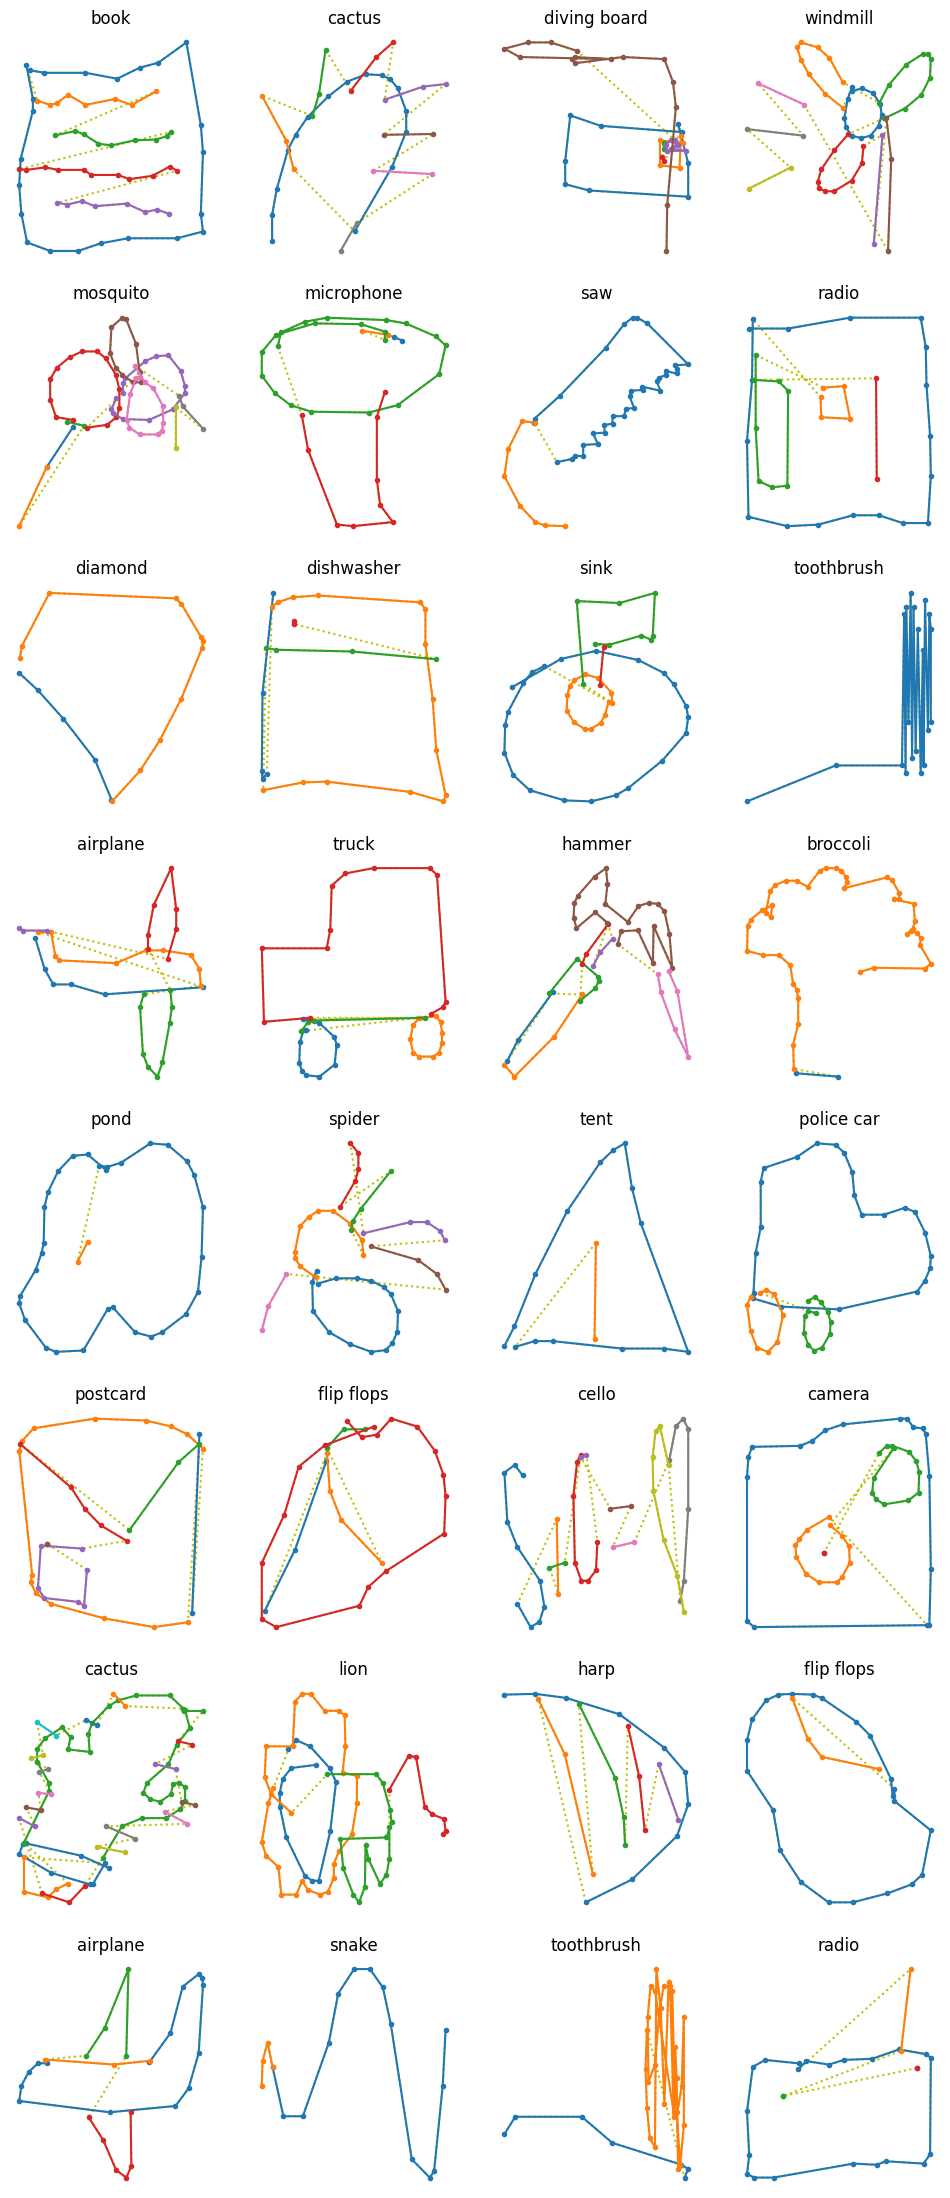

In [32]:
for sketches, lengths, labels in train_set.take(1):
    draw_sketches(sketches, lengths, labels)

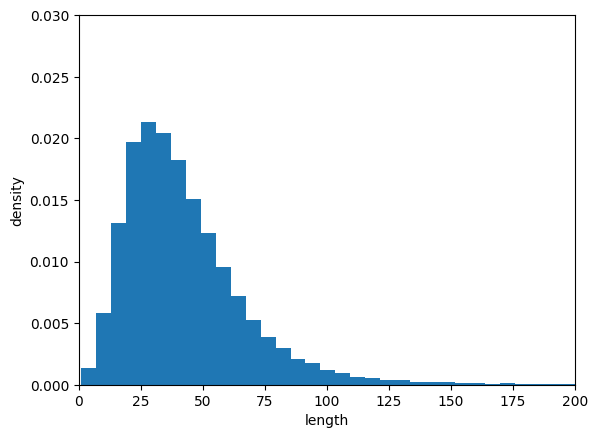

In [33]:
# 스케치 포인트 수
lengths = np.concatenate([lengths for _, lengths, _ in train_set.take(1000)])
plt.hist(lengths, bins=150, density=True)
plt.axis([0, 200, 0, 0.03])
plt.xlabel("length")
plt.ylabel("density")
plt.show()

In [34]:
model = keras.models.Sequential([
    keras.layers.Conv1D(32, kernel_size=5, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, kernel_size=5, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(128, kernel_size=3, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(128),
    keras.layers.Dense(len(class_names), activation="softmax")
])
# LSTM 기반 컨볼루션 추가

In [38]:
# 모델 컴파일
optimizer = keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy", "sparse_top_k_categorical_accuracy"])

In [41]:
# 학습 2회
history = model.fit(cropped_train_set, epochs=2,
                    validation_data=cropped_valid_set)

Epoch 1/2
107813/107813 [==============================] - 1189s 11ms/step - loss: 3.9760 - accuracy: 0.1820 - sparse_top_k_categorical_accuracy: 0.3963 - val_loss: 3.2114 - val_accuracy: 0.2824 - val_sparse_top_k_categorical_accuracy: 0.5664
Epoch 2/2
107813/107813 [==============================] - 1170s 11ms/step - loss: 2.6774 - accuracy: 0.3838 - sparse_top_k_categorical_accuracy: 0.6746 - val_loss: 2.4735 - val_accuracy: 0.4216 - val_sparse_top_k_categorical_accuracy: 0.7106


In [42]:
# 시험셋 예측
y_test = np.concatenate([labels for _, _, labels in test_set])
y_probas = model.predict(test_set)
np.mean(keras.metrics.sparse_top_k_categorical_accuracy(y_test, y_probas))

5392/5392 [==============================] - 29s 5ms/step


0.5897709

1/1 [==============================] - 1s 931ms/step


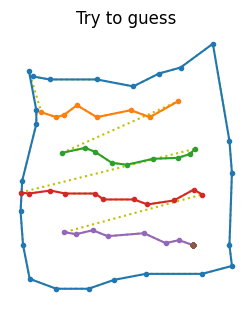

Top-5 predictions:
  1. pool 50.227%
  2. hot tub 5.394%
  3. postcard 3.361%
  4. sandwich 3.293%
  5. map 3.226%
Answer: book


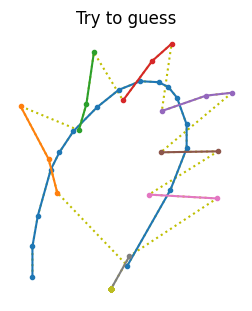

Top-5 predictions:
  1. cactus 28.713%
  2. spider 28.680%
  3. leaf 13.043%
  4. sun 12.929%
  5. flashlight 1.631%
Answer: cactus


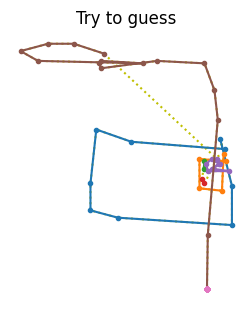

Top-5 predictions:
  1. stove 15.542%
  2. cooler 7.696%
  3. sink 5.889%
  4. oven 5.605%
  5. lantern 4.816%
Answer: diving board


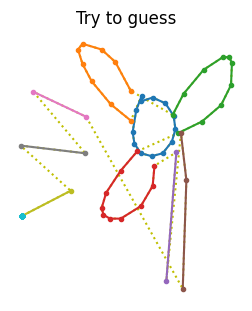

Top-5 predictions:
  1. ant 40.743%
  2. drums 28.035%
  3. mosquito 3.619%
  4. scissors 1.861%
  5. monkey 1.476%
Answer: windmill


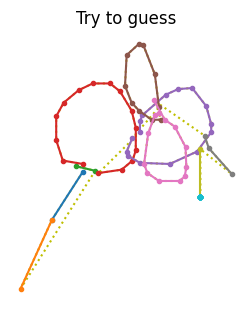

Top-5 predictions:
  1. mosquito 10.328%
  2. fan 7.902%
  3. ant 7.257%
  4. bee 3.839%
  5. lollipop 3.839%
Answer: mosquito


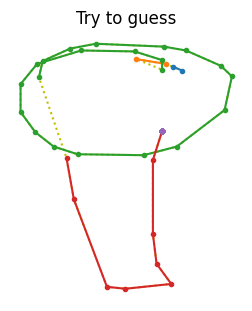

Top-5 predictions:
  1. lollipop 53.205%
  2. mushroom 12.051%
  3. ice cream 7.130%
  4. spoon 3.720%
  5. microphone 2.927%
Answer: microphone


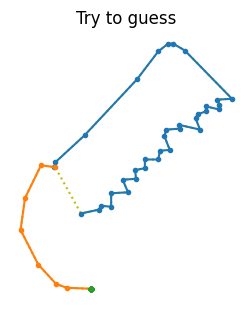

Top-5 predictions:
  1. arm 30.554%
  2. toe 8.517%
  3. tree 6.338%
  4. bush 4.244%
  5. hand 3.687%
Answer: saw


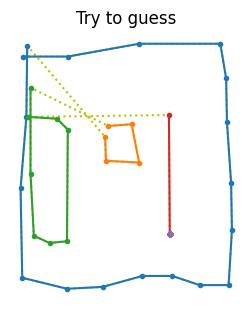

Top-5 predictions:
  1. microwave 38.655%
  2. jail 8.517%
  3. picture frame 7.422%
  4. envelope 5.083%
  5. map 5.031%
Answer: radio


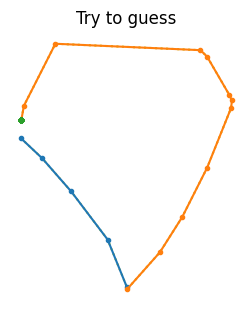

Top-5 predictions:
  1. diamond 21.891%
  2. canoe 15.631%
  3. underwear 13.008%
  4. watermelon 9.447%
  5. necklace 4.837%
Answer: diamond


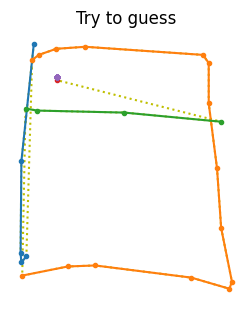

Top-5 predictions:
  1. dishwasher 20.954%
  2. dresser 15.214%
  3. oven 10.284%
  4. calculator 8.220%
  5. cell phone 6.161%
Answer: dishwasher


In [43]:
# 예측 진행 - 10가지
n_new = 10
Y_probas = model.predict(sketches)
top_k = tf.nn.top_k(Y_probas, k=5)
for index in range(n_new):
    plt.figure(figsize=(3, 3.5))
    draw_sketch(sketches[index])
    plt.show()
    print("Top-5 predictions:".format(index + 1))
    for k in range(5):
        class_name = class_names[top_k.indices[index, k]]
        proba = 100 * top_k.values[index, k]
        print("  {}. {} {:.3f}%".format(k + 1, class_name, proba))
    print("Answer: {}".format(class_names[labels[index].numpy()]))